# Show and Tell: A Neural Image Caption Generator
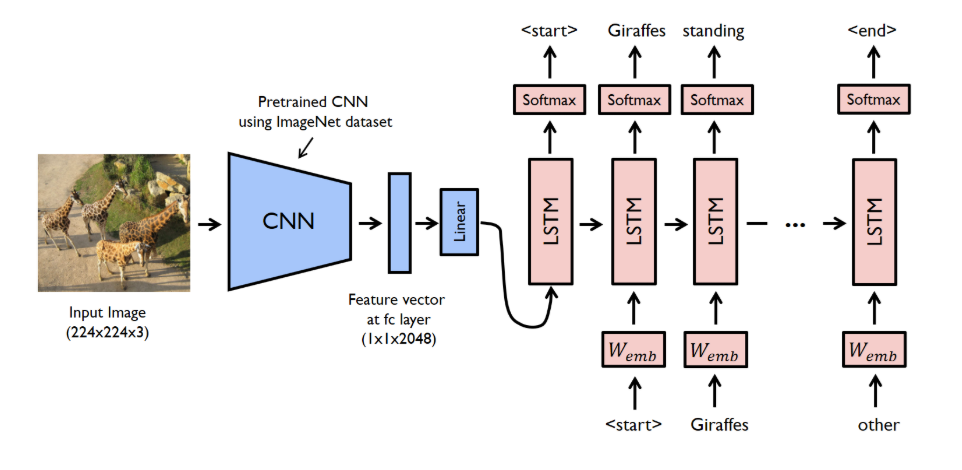

In [1]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1 -O Flickr8k_dataset.zip

--2022-11-10 13:16:37--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?ga=1 [following]
--2022-11-10 13:16:38--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1112971163 (1.0G) [application/x-zip-compressed]
Saving to: ‘Flickr8k_dataset.zip’

Flickr8k_dataset.zi 100%[===================>]   1.04G  67.1MB/s    in 16s     

2022-11-10 13:16:54 (66.5 MB/s) - 

In [2]:
%%capture
!unzip Flickr8k_dataset.zip -d ./Flickr8k_dataset

In [3]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 1.3 MB 60.4 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1


In [4]:
import os
from PIL import Image

image_dir = './Flickr8k_dataset/Images'
train_image_dir = "./resized_train/images"
val_image_dir = "./resized_val/images"
test_image_dir = "./resized_test/images"
size = [256,256]

def resize_image(image, size):
    # 임지ㅣ를 특정 크기로 지정함.
    return image.resize(size, Image.ANTIALIAS)
                        
# image_dir 내부에 있는 모든 이미지의 크기를 바꾸어 결과 폴더로 옮기기
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
    os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)

images = sorted(os.listdir(image_dir)) # 이미지와 캡션 모두 파일명으로 정렬해서 매칭함.
num_images = len(images)
num_train_images = 6000
num_val_images = 1000 

for i, image in enumerate(images):
    if (i + 1) <= num_train_images:
        output_dir = train_image_dir
    elif (i + 1) <= num_train_images + num_val_images:
        output_dir = val_image_dir
    else:
        output_dir = test_image_dir
    with open(os.path.join(image_dir, image), 'rb+') as f:
        with Image.open(f) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
    if (i + 1) % 500 == 0:
        print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")

[500/8091] Resized the images and saved into './resized_train/images'
[1000/8091] Resized the images and saved into './resized_train/images'
[1500/8091] Resized the images and saved into './resized_train/images'
[2000/8091] Resized the images and saved into './resized_train/images'
[2500/8091] Resized the images and saved into './resized_train/images'
[3000/8091] Resized the images and saved into './resized_train/images'
[3500/8091] Resized the images and saved into './resized_train/images'
[4000/8091] Resized the images and saved into './resized_train/images'
[4500/8091] Resized the images and saved into './resized_train/images'
[5000/8091] Resized the images and saved into './resized_train/images'
[5500/8091] Resized the images and saved into './resized_train/images'
[6000/8091] Resized the images and saved into './resized_train/images'
[6500/8091] Resized the images and saved into './resized_val/images'
[7000/8091] Resized the images and saved into './resized_val/images'
[7500/8091]

# 캡션을 이용해 Vocabulary 만들기


In [6]:
import pickle
import nltk
from collections import Counter

nltk.download('punkt')

caption_path = "./Flickr8k_dataset/captions.txt" # 원본 캡션(caption) 파일
vocab_path = "./vocab.pkl" # 단어 사전 결과 파일
word_threshold = 4 # 최소 단어 등장 횟수
train_caption_path = "./resized_train/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (학습)
val_caption_path = "./resized_val/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (평가)
test_caption_path = "./resized_test/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (테스트)


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<UNK>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

counter = Counter()

with open(caption_path, "r") as f:
    lines = sorted(f.readlines()[1:])
    for i in range(len(lines)):
        line = lines[i]
        if (i + 1) <= num_train_images * 5: # 이미지당 캡션이 5개씩 존재
            output_caption = train_caption_path
        elif (i + 1) <= (num_train_images + num_val_images) * 5:
            output_caption = val_caption_path
        else:
            output_caption = test_caption_path
        index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
        caption = line[index + 1:] # 캡션(caption) 문자열 기록
        tokens = nltk.tokenize.word_tokenize(caption.lower()) # 문자열 토큰화
        counter.update(tokens) # 각 토큰의 개수 세기
        with open(output_caption, "a") as output_caption_f:
            output_caption_f.write(line)

# 단어의 빈도수가 특정 임계치(threshold) 이상인 경우에만 사용
words = [word for word, cnt in counter.items() if cnt >= word_threshold]

# Vocabulary 객체 생성# 학습(train) 데이터셋의 캡션 수
!wc -l ./resized_train/captions.txt
# 평가(val) 데이터셋의 캡션 수
!wc -l ./resized_val/captions.txt
# 테스트(test) 데이터셋의 캡션 수
!wc -l ./resized_test/captions.txt
vocab = Vocabulary()
vocab.add_word('')
vocab.add_word('')
vocab.add_word('<START>')
vocab.add_word('<End>') # unknown 토큰
vocab.add_word('<UNK>')
vocab.add_word('')

# Vocabulary 객체에 모든 단어를 담기
for word in words:
    vocab.add_word(word)

# Vocabulary 파일 저장
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


30000 ./resized_train/captions.txt
5000 ./resized_val/captions.txt
5455 ./resized_test/captions.txt


In [7]:
len(vocab)

3446

In [8]:
# 학습(train) 데이터셋의 캡션 수
!wc -l ./resized_train/captions.txt
# 평가(val) 데이터셋의 캡션 수
!wc -l ./resized_val/captions.txt
# 테스트(test) 데이터셋의 캡션 수
!wc -l ./resized_test/captions.txt

30000 ./resized_train/captions.txt
5000 ./resized_val/captions.txt
5455 ./resized_test/captions.txt


# Dataset

- Flicker8kDataset 클래스를 정의합니다.

In [9]:
import torch.utils.data as data


# Flickr8k 데이터셋 클래스 정의
class Flickr8kDataset(data.Dataset):
    def __init__(self, root, captions, vocab, transform=None):
        self.root = root # 이미지가 존재하는 경로
        with open(captions, "r") as f:
             lines = f.readlines()
             self.captions = [] # 캡션(caption) 정보를 담을 리스트
             for line in lines: # 첫 번째 줄부터 바로 캡션 정보 존재
                index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
                path = line[:index] # 이미지 파일 이름
                caption = line[index + 1:] # 캡션(caption) 문자열 기록
                self.captions.append((path, caption))
        self.vocab = vocab
        self.transform = transform

    # 이미지와 캡션(caption)을 하나씩 꺼내는 메서드
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0]
        caption = self.captions[index][1]

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # 캡션(caption) 문자열을 토큰 형태로 바꾸기
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<BOS>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<EOS>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.captions)

In [10]:
def collate_fn(data):
    """
    [입력]
    * data: list of tuple (image, caption). 
        * image: torch tensor of shape (3, 256, 256).
        * caption: torch tensor of shape (?); variable length.
    [출력]
    * images: torch tensor of shape (batch_size, 3, 256, 256).
    * targets: torch tensor of shape (batch_size, padded_length).
    * lengths: list; valid length for each padded caption.
    """
    # Caption 길이로 각 데이터를 내림차순 정렬
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def collate_fn_test(data):
    # 기존 순서를 그대로 사용 (차례대로 5개씩 같은 이미지를 표현)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

# 커스텀 Flickr8k 데이터셋을 위한 DataLoader 객체 반환
def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
    return data_loader

# Model

- 학습을 위한 Encoder 및 Decoder 모델을 정의합니다.
- 본 실습에서는 사전 학습된(Pre-trained) ResNet-101 모델을 CNN으로 사용합니다.

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        # 사전 학습된(pre-trained) ResNet-101을 불러와 FC 레이어를 교체
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1] # 마지막 FC 레이어를 제거
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size) # 결과(output) 차원을 임베딩 차원으로 변경
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # 입력 이미지에서 특징 벡터(feature vectors)
        with torch.no_grad(): # 네트워크의 앞 부분은 변경되지 않도록 하기
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        # 하이퍼 파라미터(hyper-parameters) 설정 및 레이어 생성
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        # 이미지 특징 벡터(feature vectors)로부터 캡션(caption) 생성
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) # 이미지 특징과 임베딩 연결
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) # 패딩을 넣어 차원 맞추기
        hiddens, (hidden_state, cell_state) = self.lstm(packed) # 다음 hidden state 구하기
        # hiddens는 (tokenized된 sequence의 길이 , hidden_state)의 shape을 가지고 있다.
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        # 간단히 그리디(greedy) 탐색으로 캡션(caption) 생성하기
        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

# Training
- 학습 및 평가를 준비합니다.

In [12]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "models/" # 학습된 모델이 저장될 경로
crop_size = 224 # 랜덤하게 잘라낼 이미지 크기
vocab_path = "./vocab.pkl" # 전처리된 Vocabulary 파일 경로

# 모델 디렉토리 만들기
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Vocabulary 파일 불러오기
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# 사전 학습된(pre-trained) ResNet에 적용된 전처리 및 정규화 파라미터를 그대로 사용합니다.
train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

# 데이터 로더(data loader) 선언
train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False) 
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)

In [13]:
# 모델 하이퍼 파라미터 설정
embed_size = 256 # 임베딩(embedding) 차원
hidden_size = 512 # LSTM hidden states 차원
num_layers = 1 # LSTM의 레이어 개수

# 모델 객체 선언
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 5
learning_rate = 0.001

log_step = 20 # 로그를 출력할 스텝(step)
save_step = 1000 # 학습된 모델을 저장할 스텝(step)

# 손실(loss) 및 최적화 함수 선언
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

# Training Proceed

In [15]:
import torch
from torch import nn
from torchsummary import summary as summary_
from torch.nn import functional as F

In [ ]:
summary_encoder = EncoderCNN(embed_size).to(device)
summary_decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)


In [ ]:
summary_Encoder = summary_(summary_encoder, (3,256,256), batch_size=1)

In [ ]:
for i, (images, captions, lengths) in enumerate(train_data_loader):
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
    # 순전파(forward), 역전파(backward) 및 학습 진행
    print(images.shape)
    print(captions.shape)
    print(targets.shape)
    with torch.no_grad():
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
    if (i == 2):
        break


In [ ]:
import time
import numpy as np

start_time = time.time() # 전체 학습 시간 측정

# 모델 학습 진행
for epoch in range(num_epochs):

    # 먼저 학습 진행하기
    print("[ Training ]")
    total_loss = 0
    total_count = 0
    total_step = len(train_data_loader)
    for i, (images, captions, lengths) in enumerate(train_data_loader):
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # 순전파(forward), 역전파(backward) 및 학습 진행
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실(loss) 값 계산
        total_loss += loss.item()
        total_count += images.shape[0]

        # 로그(log) 정보 출력
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                  .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

    # 모델 파일 저장하기
    torch.save(decoder.state_dict(), os.path.join(model_path, f'decoder-{epoch + 1}.ckpt'))
    torch.save(encoder.state_dict(), os.path.join(model_path, f'encoder-{epoch + 1}.ckpt'))
    print(f"Model saved: {os.path.join(model_path, f'decoder-{epoch + 1}.ckpt')}")
    print(f"Model saved: {os.path.join(model_path, f'encoder-{epoch + 1}.ckpt')}")

    # 학습 이후에 평가 진행하기
    print("[ Validation ]")
    total_loss = 0
    total_count = 0
    total_step = len(val_data_loader)
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(val_data_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # 순전파(forward) 진행
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
  
            # 손실(loss) 값 계산
            total_loss += loss.item()
            total_count += images.shape[0]

            # 로그(log) 정보 출력
            if i % log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                      .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

In [ ]:
from google.colab import files

files.download('models/encoder-5.ckpt')
files.download('models/decoder-5.ckpt')

# Evaluation Dataset Download

In [16]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERnDZFI8KD9OrX8rZGB4zucBLL1C2OQl5zdEIj9M23VH8A?download=1 -O nic_encoder_ResNet101.ckpt
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfpMfIRuTy1NndX8U7C70XMBmu6wd3JofEo5T-uyIP8YOA?download=1 -O nic_decoder_ResNet101.ckpt


--2022-11-10 13:19:43--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERnDZFI8KD9OrX8rZGB4zucBLL1C2OQl5zdEIj9M23VH8A?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/nic_encoder_ResNet101.ckpt?ga=1 [following]
--2022-11-10 13:19:44--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/nic_encoder_ResNet101.ckpt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 172740767 (165M) [application/octet-stream]
Saving to: ‘nic_encoder_ResNet101.ckpt’

nic_encoder_ResNet1 100%[===================>] 164.74M  46.0MB/s    in 3.6s    

2022-11-10 13:19:48 (46.0

In [17]:
from glob import glob
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

image_path = "./resized_test/images/872622575_ba1d3632cc.jpg" # 캡션(caption)을 생성할 입력 이미지
# image_path = glob("./resized_test/images/*")[-2] # 캡션(caption)을 생성할 입력 이미지
encoder_path = "./nic_encoder_ResNet101.ckpt" # path for trained encoder
decoder_path = "./nic_decoder_ResNet101.ckpt" # path for trained decoder
# encoder_path = "./models/encoder-5.ckpt" # path for trained encoder
# decoder_path = "./models/decoder-5.ckpt" # path for trained decoder
vocab_path = "./vocab.pkl" # path for vocabulary wrapper

# Model parameters (should be same as paramters in train.py)
embed_size = 256 # dimension of word embedding vectors
hidden_size = 512 # dimension of lstm hidden states
num_layers = 1 # number of layers in lstm

In [18]:
# 이미지 전처리(image preprocessing)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size).eval() # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image = load_image(image_path, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
    sampled_caption.append(word)
    if word == '<End>':
        break
sentence = ' '.join(sampled_caption)

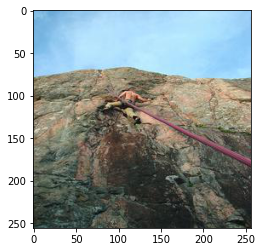

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지 및 생성된 캡션(caption) 문장 출력
image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
print(sentence)

# BLEU Score 
- BLEU 점수 계산

In [ ]:
predictions = []
answers = []
answers_per_image = []

total_step = len(test_data_loader)
cnt = 0

with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(test_data_loader):
        images = images.to(device)
        captions = captions.to(device)
        # print(captions.shape)
        # 순전파(forward) 진행
        features = encoder(images)
        sampled_ids_list = decoder.sample(features)

        for index in range(len(images)):
            sampled_ids = sampled_ids_list[index].cpu().numpy()

            # 정답 문장(answer sentences)
            answer = []
            for word_id in captions[index]: # 하나씩 단어 인덱스를 확인하며
                word = vocab.idx2word[word_id.item()] # 단어 문자열로 바꾸어 삽입
                answer.append(word)
                if word == '<End>':
                    break
            answers_per_image.append(answer[1:-1]) # 정답 문장을 삽입 (과 는 제외)

            if (cnt + 1) % 5 == 0: # 이미지당 캡션이 5개씩 존재
                answers.append(answers_per_image) # 5개를 한꺼번에 리스트로 삽입
                answers_per_image = []

                # 예측한 문장(predicted sentences)
                prediction = []
                for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
                    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
                    prediction.append(word)
                    if word == '<End>':
                        break
                predictions.append(prediction[1:-1]) # 예측한 문장에 대해서는 1개만 삽입 (과 는 제외)
            cnt += 1

        if i % log_step == 0:
            print(f"[ Testing ] Batch size: {i}/{total_step}")


torch.Size([128, 27])
[ Testing ] Batch size: 0/43
torch.Size([128, 26])
torch.Size([128, 25])
torch.Size([128, 24])
torch.Size([128, 26])
torch.Size([128, 28])
torch.Size([128, 31])
torch.Size([128, 24])
torch.Size([128, 25])
torch.Size([128, 29])
torch.Size([128, 30])
torch.Size([128, 25])
torch.Size([128, 24])
torch.Size([128, 31])
torch.Size([128, 26])
torch.Size([128, 31])
torch.Size([128, 27])
torch.Size([128, 26])
torch.Size([128, 32])
torch.Size([128, 30])
torch.Size([128, 31])
[ Testing ] Batch size: 20/43
torch.Size([128, 25])
torch.Size([128, 30])
torch.Size([128, 26])
torch.Size([128, 26])
torch.Size([128, 30])
torch.Size([128, 27])
torch.Size([128, 27])
torch.Size([128, 31])
torch.Size([128, 26])
torch.Size([128, 28])
torch.Size([128, 36])
torch.Size([128, 29])
torch.Size([128, 27])
torch.Size([128, 31])
torch.Size([128, 26])
torch.Size([128, 30])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128, 30])
torch.Size([128, 28])
[ Testing ] Batch size: 40/43
torch.Siz

In [ ]:
answers[:10]

[[['shallow',
   'grinds',
   'protection',
   'with',
   'building',
   'laying',
   'fighting',
   'staring',
   'water',
   'paved',
   'three',
   'stairs',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   ''],
  ['individual',
   'climbing',
   'staring',
   'airborne',
   'points',
   'motorcyclists',
   'with',
   'building',
   'stump',
   'little',
   'towards',
   'building',
   'head',
   'stairs',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   ''],
  ['airborne',
   'protection',
   'with',
   'building',
   'laying',
   'and',
   'looks',
   'building',
   'head',
   'stairs',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   ''],
  ['building',
   'grinds',
   'protection',
   '<UNK>',
   'ears',
   'dog',
   'mountaineer',
   'building',
   'female',
   '<UNK>',
   'nearby',
   'little',
   'building',
   'laying',
   'stairs',
   '',
   '',
   '',
   '',
  

In [ ]:
print("예측한 문장의 수:", len(predictions))
print("정답 문장 집합의 수 (5개씩):", len(answers))

예측한 문장의 수: 1091
정답 문장 집합의 수 (5개씩): 1091


In [ ]:
index = 2
print("[ 정답 캡션들 ]")
for answer in answers[index]:
    print(answer)

print("[ 예측된 캡션 ]")
print(predictions[index])

[ 정답 캡션들 ]
['<START>', 'on', 'cabin', 'other', 'her', 'in', 'are', 'fighting', '<START>', 'about', '<UNK>', '<START>', 'stump', 'climbing', 'terrier', 'sitting', 'cabin', 'guitars', 'stairs', '', '', '', '', '', '']
['<START>', 'on', 'cabin', 'other', 'her', 'bends', '<START>', 'other', 'operating', 'about', '<UNK>', '<START>', 'stump', 'climbing', 'guitars', 'stairs', '', '', '', '', '', '', '', '', '']
['<START>', 'surfs', 'closes', 'climbing', '<START>', 'are', 'her', '<UNK>', '<START>', 'talking', 'stump', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<START>', 'her', '<UNK>', 'sitting', 'as', '<START>', 'about', '<UNK>', 'near', 'cars', 'stairs', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['building', 'into', 'on', 'her', 'in', 'playground', 'grassy', '<START>', 'guitars', 'stump', 'fighting', '<START>', 'other', 'prepares', '<UNK>', 'near', 'cars', 'stairs', '', '', '', '', '', '', '']
[ 예측된 캡션 ]
['a', 'dog', 'runs', 'through', 'the', 'grass', '.']


In [ ]:
from torchtext.data.metrics import bleu_score

bleu = bleu_score(predictions, answers, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
print(f'Total BLEU Score = {bleu * 100:.2f}')

individual_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
individual_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[0, 1, 0, 0])
individual_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[0, 0, 1, 0])
individual_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[0, 0, 0, 1])

print(f'Individual BLEU1 score = {individual_bleu1_score * 100:.2f}') 
print(f'Individual BLEU2 score = {individual_bleu2_score * 100:.2f}') 
print(f'Individual BLEU3 score = {individual_bleu3_score * 100:.2f}') 
print(f'Individual BLEU4 score = {individual_bleu4_score * 100:.2f}') 

cumulative_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
cumulative_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[1/2, 1/2, 0, 0])
cumulative_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[1/3, 1/3, 1/3, 0])
cumulative_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

print(f'Cumulative BLEU1 score = {cumulative_bleu1_score * 100:.2f}') 
print(f'Cumulative BLEU2 score = {cumulative_bleu2_score * 100:.2f}') 
print(f'Cumulative BLEU3 score = {cumulative_bleu3_score * 100:.2f}') 
print(f'Cumulative BLEU4 score = {cumulative_bleu4_score * 100:.2f}') 
# BLEU score가 잘 안나오는 이유는 word bag(word embedding이 기존의 방식과 달라서 그렇지 않을까 추측함.)

Total BLEU Score = 0.00
Individual BLEU1 score = 0.00
Individual BLEU2 score = 0.00
Individual BLEU3 score = 0.00
Individual BLEU4 score = 0.00
Cumulative BLEU1 score = 0.00
Cumulative BLEU2 score = 0.00
Cumulative BLEU3 score = 0.00
Cumulative BLEU4 score = 0.00
